## Install / Import

In [ ]:
!pip install -U sentence-transformers
!pip install scipy

In [ ]:
from sentence_transformers import SentenceTransformer
import os
import pandas as pd
import numpy as np
import scipy
from tqdm import tqdm

In [1]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image
import warnings
import re
import pickle

warnings.filterwarnings("ignore")

In [2]:
# device : gpu를 사용할 경우에는 'cuda', 그렇지 않을 경우에는 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 랜덤 시드 고정.
# 실험 조건을 동일하게 설정하여,
# 같은 input을 넣으면 같은 결과가 나올 수 있도록 함.
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

## Data load

image data 불러오기
text data 불러오기

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
%cd /content/gdrive/MyDrive/Multi-model Searching

/content/gdrive/.shortcut-targets-by-id/13n8KdEmTOJCumunRKYWJSfpsdqRNjVDz/Multi-model Searching


In [6]:
# 테스트 이미지 경로 지정
test_image_path= 'data/test_imageset/city_1.jpg'
# db 이미지 경로 지정
db_image_path = 'data/db_imageset/'
# 이미지 벡터 딕셔너리 경로 지정
img_vector_dict_path = 'data/db_imageset/resultvectors/img_vector_dict_resnet18.pkl'

In [7]:
# review 데이터 경로 지정 및 dataframe 불러오기
data_path = 'data/processed_txt/'
file_list = os.listdir(data_path)
print(file_list)

['Acropolis.csv', 'AlhambraGranada.csv', 'AngelFalls.csv', 'AngkorWat.csv', 'MontSaintMichel.csv', 'AmazonRainforest.csv', 'Baalbek.csv', 'BanffNationalPark.csv', 'BoraBoraFrench.csv', 'BorobudurTemple.csv', 'BritishMuseum.csv', 'BryceCanyon.csv', 'CarlsbadCavernsNationalPark.csv', 'CastelloBrown.csv', 'ChurchoftheHolySepulchre.csv', 'CordobaMesquita.csv', 'EasterIsland.csv', 'EiffelTower.csv', 'ElCastillo97751Tinum.csv', 'FortLovrijenac.csv', 'Giant’sCauseway.csv', 'Golden Gate Bridge.csv', 'GoldenTemple.csv', 'GoremeHistoricalNationalPark.csv', 'GrandCanyon.csv', 'GreatWall.csv', 'HagiaSophia.csv', 'HermitageMuseumofArt.csv', 'IguazuFalls.csv', 'Karnak.csv', 'KathmanduValley.csv', 'Louvre.csv', 'MachuPicchu.csv', 'MasjidAlHaram.csv', 'Matterhorn.csv', 'MeenakshiAmmanTemple.csv', 'NeuschwansteinCastle.csv', 'NgorongoroConservationArea.csv', 'NiagaraFalls.csv', 'OldTownSquare.csv', 'PalaceofVersailles.csv', 'PetraJordan.csv', 'PetronasTowers.csv', 'PompeiiArchaeologicalPark.csv', 'Pont

In [ ]:
file_name = []
for name in file_list:
    if name.endswith('.csv'):
        new_file_name = name[:-4]  # .xlsx의 길이는 5
        file_name.append(new_file_name)
print(file_name)

['Acropolis', 'AlhambraGranada', 'AngelFalls', 'AngkorWat', 'MontSaintMichel', 'AmazonRainforest', 'Baalbek', 'BanffNationalPark', 'BoraBoraFrench', 'BorobudurTemple', 'BritishMuseum', 'BryceCanyon', 'CarlsbadCavernsNationalPark', 'CastelloBrown', 'ChurchoftheHolySepulchre', 'CordobaMesquita', 'EasterIsland', 'EiffelTower', 'ElCastillo97751Tinum', 'FortLovrijenac', 'Giant’sCauseway', 'Golden Gate Bridge', 'GoldenTemple', 'GoremeHistoricalNationalPark', 'GrandCanyon', 'GreatWall', 'HagiaSophia', 'HermitageMuseumofArt', 'IguazuFalls', 'Karnak', 'KathmanduValley', 'Louvre', 'MachuPicchu', 'MasjidAlHaram', 'Matterhorn', 'MeenakshiAmmanTemple', 'NeuschwansteinCastle', 'NgorongoroConservationArea', 'NiagaraFalls', 'OldTownSquare', 'PalaceofVersailles', 'PetraJordan', 'PetronasTowers', 'PompeiiArchaeologicalPark', 'PonteVecchio', 'PotalaPalace', 'QinShiHuang', 'RialtoBridge', 'RomeColosseum', 'SaharaDesert', 'Santorini', 'SeongsanIlchulbong', 'Serengeti', 'ShwedagonPagoda', 'SistineChapel', "

## Image Filtering

1. img vector 불러오기
2. img vector와 input img cosine similarity 연산
3. 유사 img가 존재하는 여행지 명 출력

### 1. 모델 불러오기

In [8]:
def load_feature_extractor(arch):
  # device : gpu를 사용할 경우에는 'cuda', 그렇지 않을 경우에는
  # th architecture to use
  # load the pre-trained weights
  model_file = '%s_places365.pth.tar' % arch
  if not os.access(model_file, os.W_OK):
      weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
      os.system('wget ' + weight_url)

  model = models.__dict__[arch](num_classes=365)
  checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
  state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
  model.load_state_dict(state_dict)
  model.eval()

  feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # 마지막 FC 레이어 제외
  return feature_extractor

### 2. img vector 불러오기

In [9]:
# db 이미지 벡터 딕셔너리 불러오기
def load_img_vector_dict(path):
# 파일 열기
  with open(path, 'rb') as f:
      # 딕셔너리 불러오기
      img_vector_dict = pickle.load(f)

  return img_vector_dict

img_vector_dict = load_img_vector_dict(img_vector_dict_path)

# 인풋 이미지에 대한 벡터라이징 함수
def encode(img_path, feature_extractor):
  # 모델의 feature extractor을 받아서 사용
  # 이미지 전처리를 위한 변환 정의
  preprocess = trn.Compose([
      trn.Resize(256),  # 이미지 크기 조정
      trn.CenterCrop(224),  # 이미지 가운데 부분을 잘라냄
      trn.ToTensor(),  # 이미지를 텐서로 변환
      trn.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 이미지를 정규화
  ])
  img = Image.open(img_path).convert('RGB')
  input_tensor = preprocess(img).to(device)
  feature_extractor.to(device)
  input_batch = input_tensor.unsqueeze(0)
  with torch.no_grad():  # 그라디언트 계산 비활성화
    output = feature_extractor(input_batch)
  vec = output.view(-1)
  return vec

### 3. img vector와 input img cosine similarity 연산

In [10]:
# Compute the cosine similarity
def Compute_cosine_similarity(vec1, vec2):
  cos_sim = F.cosine_similarity(vec1, vec2, dim=0)
  # print("Cosine similarity:", cos_sim.item())
  return cos_sim.item()

# compute cosine similarity with input image for all db image
def test(test_img_path, feature_extractor, img_vector_dict) :
  vec1=encode(test_img_path, feature_extractor)
  database = pd.DataFrame(columns=["path", "similarity", 'landmark'])
  # Loop through all keys in img_vector_dict
  for key in img_vector_dict.keys():
      vec2 = img_vector_dict[key][0]
      similarity = Compute_cosine_similarity(vec1, vec2)
      filename = key.split('/')[-1].split('.')[0]
      landmark=extract_landmark_name(key)
      database = database.append({"path": key, "similarity": similarity, 'landmark': landmark }, ignore_index=True)
  return database

#### 기타 함수

In [11]:
# 경로로부터 여행지명 추출
def extract_landmark_name(path):
  filename = path.split('/')[-1]
  filename = re.sub(r'\.(png|jpg|jpeg|gif|bmp)$', '', filename)
  landmarkname = re.sub(r'\d+|[\']', '', filename)
  landmarkname = landmarkname.replace('_', "'")
  return landmarkname

# 이미지 시각화
def visualize_image(image_path):
    # Read the image
    img = mpimg.imread(image_path)

    # Create a figure and display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### 4. 유사 img가 존재하는 여행지 명 출력

In [12]:
def run(test_image_path, db_image_path):
  # 모델 불러오기
  feature_extractor=load_feature_extractor('resnet18')
  # 벡터 딕셔너리 불러오기
  # img_vector_dict = load_img_vector_dict('data/db_imageset/resultvectors/img_vector_dict_resnet18.pkl')

  # 테스트 이미지 시각화
  print("Test image:")
  visualize_image(test_image_path)

  # 테스트
  database=test(test_image_path, feature_extractor, img_vector_dict)

  # 이미지 상위 다섯개 뽑아서 중복제거
  database = database.sort_values(by="similarity", ascending=False).head(5)
  database.drop_duplicates(subset='landmark', keep='first', inplace=True)
  landmarks = database.landmark.tolist()
  print("\n tour recommendations: \n")

  c=0
  # 중목제거한 이미지 시각화
  for row in database.itertuples():
    c+=1
    image_path = os.path.join(db_image_path, row.path)
    similarity = row.similarity
    landmark = row.landmark

    print(f"number {c} : {landmark}")
    visualize_image(image_path)
    print(f"similarity : {similarity}% \n")

  return landmarks

Test image:


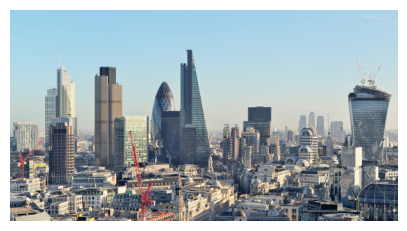


 tour recommendations: 

number 1 : PetronasTowers


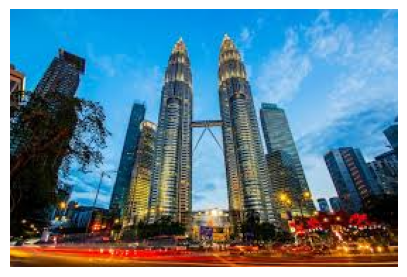

similarity : 0.7829306721687317% 

number 2 : PetronasTowers


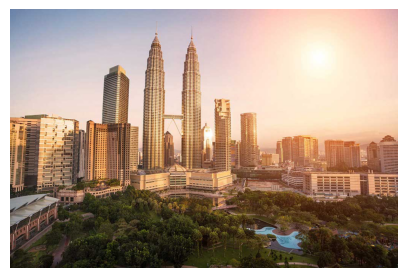

similarity : 0.7663997411727905% 

number 3 : PetronasTowers


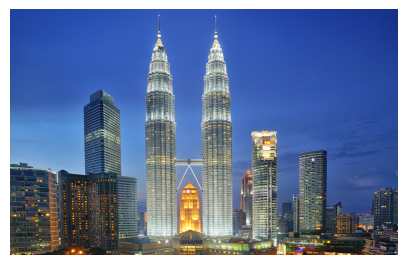

similarity : 0.7532467842102051% 

number 4 : GangesRiver


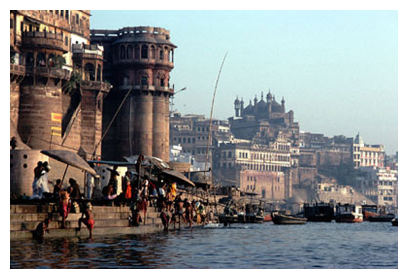

similarity : 0.7527099251747131% 

number 5 : EiffelTower


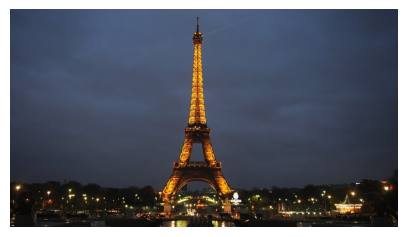

similarity : 0.6805341839790344% 



In [13]:
result= run(test_image_path, db_image_path)

In [ ]:
print(result)

['SaharaDesert', 'AyersRock']


## Text Semantic Search

### filtered reviews

In [ ]:
df = pd.DataFrame()

for i in range(len(file_list)):
  tmp = pd.read_csv(data_path + file_list[i])
  txt_list = list(tmp['no_stopwords'])
  while len(txt_list) < 500:
    txt_list.append('None')

  df[str(file_name[i])] = txt_list

In [ ]:
filtered_df = df[['SaharaDesert', 'AyersRock']]

### model load

In [ ]:
model_roberta = SentenceTransformer('roberta-large-nli-mean-tokens')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

### embedding reviews

In [ ]:
places = filtered_df.columns
# model_mpnet
roberta_embeddings = pd.DataFrame()
for place in tqdm(places, desc="Processing places"):
  embeddings = model_roberta.encode(list(df[place]))
  roberta_embeddings[place] = list(embeddings)
roberta_embeddings

Processing places: 100%|██████████| 2/2 [00:11<00:00,  5.82s/it]


,SaharaDesert,AyersRock
0,"[0.4412109, 0.38069832, -0.984832, 0.07944657,...","[0.54769194, 0.72630394, -0.7194242, -0.156887..."
1,"[-0.11730301, 0.79230833, 0.031359658, 0.91310...","[0.15767409, 0.6498075, -0.69962305, 1.3037734..."
2,"[1.2684788, 0.7496728, -0.30698302, 1.783528, ...","[1.3108671, 0.22175497, -0.60834974, -0.533296..."
3,"[1.1613268, -0.5649537, -0.14256448, 0.2686517...","[-0.06812679, 0.5696519, -0.47833866, 0.271032..."
4,"[0.7677672, 0.76108104, -0.6468659, 0.15321928...","[0.29288974, 1.0135684, -0.6684716, 0.13419801..."
...,...,...
495,"[0.5375521, 0.97404224, -0.44077203, 0.1921901...","[-0.22581023, -0.65316516, -0.62369764, 1.5068..."
496,"[0.05202908, 0.5977206, -0.121340245, 0.824451...","[-0.22581023, -0.65316516, -0.62369764, 1.5068..."
497,"[0.18468879, 0.9958747, -0.33451504, 0.8563884...","[-0.22581023, -0.65316516, -0.62369764, 1.5068..."
498,"[-0.37615076, 0.46685106, -0.2297468, 0.301698...","[-0.22581023, -0.65316516, -0.62369764, 1.5068..."


In [ ]:
# sample query
query = 'recommend to go'  #  A query sentence uses for searching semantic similarity score.
queries = [query]
#query_embeddings_nli = model_nli.encode(queries)
#query_embeddings_roberta = model_roberta.encode(queries)
query_embeddings_mpnet = list(model_roberta.encode(queries))

In [ ]:
print("Semantic Search Results")

for query, query_embeddings in zip(queries, query_embeddings_mpnet):
    for spot in roberta_embeddings.columns:
      embeddings_list = list(roberta_embeddings[spot])
      embeddings_list = [arr.tolist() for arr in embeddings_list]
      distances = scipy.spatial.distance.cdist(query_embeddings_mpnet, embeddings_list, "cosine")[0]

      results = zip(range(len(distances)), distances)
      results = sorted(results, key=lambda x: x[1])
      print("Query:", query)
      print("\nTop 5 most similar sentences in corpus:")

      for idx, distance in results[0:5]:
          sample_list = list(df[spot])
          print(sample_list[idx].strip(), "(Cosine Score: %.4f)" % (1-distance))

Semantic Search Results
Query: recommend to go

Top 5 most similar sentences in corpus:
['havent', 'came', 'wanna', 'go', 'sometime'] (Cosine Score: 0.8176)
['saw', 'sand', '1010', 'would', 'recommend'] (Cosine Score: 0.7384)
['dream', 'visit', ''] (Cosine Score: 0.7367)
['hot', 'dont', 'recommend', 'going', 'place'] (Cosine Score: 0.7283)
['nice', 'hope', 'starts', 'expanding', 'everyone', 'enjoy'] (Cosine Score: 0.7282)
Query: recommend to go

Top 5 most similar sentences in corpus:
['experience', 'like', '100', 'recommended'] (Cosine Score: 0.7783)
['great', 'experience', 'highly', 'recommended', 'see', ''] (Cosine Score: 0.7781)
['fabulous', 'recommend', 'guided', 'tours', 'better', 'experience'] (Cosine Score: 0.7610)
['awesome', 'place', 'must', 'go', 'havent', '', ''] (Cosine Score: 0.7489)
['amazing', 'absolutely', 'worth', 'coming', 'visit'] (Cosine Score: 0.7488)
